In [1]:
import os # Handle OS file systems and directory paths
import random # Random number
import numpy as np # Import NumPy for arrays and such
import matplotlib.pyplot as plt # Plotting Tools
import numpy.linalg as npl # Linear Algebra Library
import time # Time
# from google.colab import drive # Read files in from Google Drive
import pandas as pd # Import Pandas for data processing
import datetime as dt
import scipy.io as sio
import io
from decimal import Decimal # String to double conversion
from glob import glob  # 从 glob 模块中导入 glob 函数

Matplotlib is building the font cache; this may take a moment.


In [2]:
import boto3
from botocore.exceptions import NoCredentialsError

In [3]:
# Optionally, you can specify the AWS region
s3 = boto3.client('s3', region_name='us-east-1')  # Replace 'us-west-2' with your AWS region

In [4]:
import pandas as pd
# s3_uri = 's3://pepper-dataset/crop_data/crop_IOWA/Iowa_corn_2019.csv'
# df = pd.read_csv(s3_uri)

In [5]:
# get county list
# county_path_list = glob('/content/drive/MyDrive/ai/era5/county_env/*')
# county_list = [os.path.basename(x) for x in county_path_list]
# print(county_list)

#Read files from s3
bucket_name = 'pepper-dataset'
prefix = 'county-env-data/county_env_2_IL_AK_MN/processed_with_all_features/'

# List to store all object keys
county_files = []

# Initial call to list_objects_v2
response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)

# Process the initial response
while True:
    # Collect keys from current response
    current_keys = [obj['Key'] for obj in response.get('Contents', [])]
    county_files.extend(current_keys)

    # Check if there are more objects to retrieve
    if not response['IsTruncated']:
        break  # No more objects to retrieve

    # Get ContinuationToken for next paginated call
    continuation_token = response['NextContinuationToken']

    # Make subsequent call with ContinuationToken
    response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix, ContinuationToken=continuation_token)
    
    
county_files = ["/" + path if not path.startswith("/") else path for path in county_files]

In [6]:
len(county_files)

81217

In [7]:
county_files[:10]

['/county-env-data/county_env_2_IL_AK_MN/processed_with_all_features/',
 '/county-env-data/county_env_2_IL_AK_MN/processed_with_all_features/Arkansas_Jackson/Arkansas_Jackson_2000-01_part1.csv',
 '/county-env-data/county_env_2_IL_AK_MN/processed_with_all_features/Arkansas_Jackson/Arkansas_Jackson_2000-01_part2.csv',
 '/county-env-data/county_env_2_IL_AK_MN/processed_with_all_features/Arkansas_Jackson/Arkansas_Jackson_2000-02_part1.csv',
 '/county-env-data/county_env_2_IL_AK_MN/processed_with_all_features/Arkansas_Jackson/Arkansas_Jackson_2000-02_part2.csv',
 '/county-env-data/county_env_2_IL_AK_MN/processed_with_all_features/Arkansas_Jackson/Arkansas_Jackson_2000-03_part1.csv',
 '/county-env-data/county_env_2_IL_AK_MN/processed_with_all_features/Arkansas_Jackson/Arkansas_Jackson_2000-03_part2.csv',
 '/county-env-data/county_env_2_IL_AK_MN/processed_with_all_features/Arkansas_Jackson/Arkansas_Jackson_2000-04_part1.csv',
 '/county-env-data/county_env_2_IL_AK_MN/processed_with_all_feature

In [8]:
# try 1 county
year_range = [2015, 2020]
years = [x for x in range(year_range[0], year_range[-1]+1)]

filtered_files = [file_path for file_path in county_files
                  if any(str(year) in file_path for year in years)]

# basedir = '/content/drive/MyDrive/ai/era5/county_env/'
# county_files = []

# for c in county_list:
#   county = os.path.join(basedir, c)
#   print(county)

#   county_f = glob(os.path.join(county, '*'))

#   for f in county_f:
#     ym_str = f.split('_')[-2]
#     ym_obj = dt.datetime.strptime(ym_str, '%Y-%m')
#     if ym_obj.year not in years:
#         continue
#     county_files.append(f)

print(len(filtered_files))

  # print(len(county_files))
  # print(county_files[:3])

# get year-month info for the county
# ym_list = [x.split('_')[-2] for x in county_files]
# ym_list = list(set(ym_list))
# ym_list.sort()
# print(ym_list)

filtered_files[:50]


20304


['/county-env-data/county_env_2_IL_AK_MN/processed_with_all_features/Arkansas_Jackson/Arkansas_Jackson_2015-01_part1.csv',
 '/county-env-data/county_env_2_IL_AK_MN/processed_with_all_features/Arkansas_Jackson/Arkansas_Jackson_2015-01_part2.csv',
 '/county-env-data/county_env_2_IL_AK_MN/processed_with_all_features/Arkansas_Jackson/Arkansas_Jackson_2015-02_part1.csv',
 '/county-env-data/county_env_2_IL_AK_MN/processed_with_all_features/Arkansas_Jackson/Arkansas_Jackson_2015-02_part2.csv',
 '/county-env-data/county_env_2_IL_AK_MN/processed_with_all_features/Arkansas_Jackson/Arkansas_Jackson_2015-03_part1.csv',
 '/county-env-data/county_env_2_IL_AK_MN/processed_with_all_features/Arkansas_Jackson/Arkansas_Jackson_2015-03_part2.csv',
 '/county-env-data/county_env_2_IL_AK_MN/processed_with_all_features/Arkansas_Jackson/Arkansas_Jackson_2015-04_part1.csv',
 '/county-env-data/county_env_2_IL_AK_MN/processed_with_all_features/Arkansas_Jackson/Arkansas_Jackson_2015-04_part2.csv',
 '/county-env-da

In [9]:
pd.read_csv('s3://'+bucket_name+filtered_files[0])

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/fsspec/registry.py:279: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


,t2m,rsn,sde,stl1,stl2,stl3,stl4,tsn,swvl1,swvl2,swvl3,swvl4,datetime
0,1010.666667,-25195.800000,-32766.0,-7531.800000,-1533.400000,400.333333,1179.266667,25135.733333,5722.333333,6580.800000,2787.333333,6270.933333,2015-01-01 00:00:00
1,455.466667,-25021.000000,-32766.0,-8140.733333,-1605.466667,371.333333,1169.466667,23691.400000,5717.800000,6567.200000,2790.933333,6270.866667,2015-01-01 01:00:00
2,388.666667,-24844.133333,-32766.0,-8397.533333,-1692.266667,342.333333,1161.333333,24787.133333,5715.333333,6553.533333,2794.666667,6270.866667,2015-01-01 02:00:00
3,471.066667,-24659.066667,-32766.0,-8472.133333,-1779.266667,312.866667,1153.800000,26445.200000,5710.933333,6540.066667,2798.600000,6270.733333,2015-01-01 03:00:00
4,506.000000,-24463.666667,-32766.0,-8487.200000,-1861.266667,282.333333,1144.266667,27897.533333,5705.333333,6526.333333,2802.133333,6270.733333,2015-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,7277.000000,-19673.133333,-32766.0,-2578.333333,1113.266667,-1741.266667,-5683.200000,32766.000000,2941.600000,4195.666667,6174.266667,6473.133333,2015-01-31 19:00:00
740,7357.933333,-19870.266667,-32766.0,-2443.533333,1259.066667,-1748.533333,-5688.600000,32766.000000,2917.600000,4183.666667,6170.533333,6473.333333,2015-01-31 20:00:00
741,7219.533333,-19863.000000,-32766.0,-2649.800000,1378.800000,-1754.866667,-5695.133333,32767.000000,2902.666667,4174.466667,6167.866667,6473.533333,2015-01-31 21:00:00
742,7216.266667,-20187.466667,-32766.0,-2680.533333,1487.400000,-1758.933333,-5699.533333,32766.000000,2888.133333,4165.733333,6165.333333,6473.533333,2015-01-31 22:00:00


In [10]:
df_list = pd.DataFrame(columns=("Year","State","County","Month","Commodity","Feature"))

for csvf in filtered_files:
    # only read part1, then match with part2
    if 'part2' in csvf:
        continue
    # print(csvf)
    crop = "UNKNOWN"

    suffix = csvf.split('/')[-1]
    state = suffix.split('_')[-4].upper()
    # print(state)
    if state != "IOWA":
        continue
    county_name = suffix.split('_')[-3].upper()
    ym_str = csvf.split('_')[-2]

    year = int(suffix.split('-')[0][-4:])
    month = int(suffix.split('-')[1][:2])
    ym_obj = dt.datetime.strptime(ym_str, '%Y-%m')
    if ym_obj.year not in years:
        continue
    # else:
    #     print(ym_str)
        # pass

    df1 = pd.read_csv('s3://'+bucket_name+csvf)
    # df1.dropna(axis=1)
    csvf_part2 = csvf.replace('part1', 'part2')
    df2 = pd.read_csv('s3://'+bucket_name+csvf_part2)
    # df2.dropna(axis=1)


    df12 = pd.merge(df1, df2, on = 'datetime')
    
    df12 = df12.drop(columns=['sshf'])
    df12 = df12.drop(columns=['evavt'])
    
    df12['datetime'] = pd.to_datetime(df12['datetime'])
    # print("----------------------")
    # print(df12[df12['datetim-e'].dt.month >= 5])
    # df12 = df12[df12['datetime'].dt.month >= 5]
    # print(df12['datetime'].dt.month)
    df12 = df12[(df12['datetime'].dt.month >= 5) & (df12['datetime'].dt.month <= 11)]
    if df12.empty:
        print("No data available after filtering.")
        continue
      # drop datetime
    df12 = df12.drop(columns=['datetime'])
    
    # df12.drop(columns=['datetime'])
    # print(df12.head())
    # print("size:", len(df12))
    # print(df12.dtype)

    # print("-----------------------")
    # print(df12.shape)
    row = [year,state,county_name,month,crop]
    row.append(df12)
    # print(row[:4])

    # df_list.append(df12)
    dfLength = len(df_list)
    df_list.loc[dfLength] = row

# df_all = df_list[0]
# for df in df_list[1:]:
#     df_all = pd.concat([df_all, df], axis = 0)

print("Number of Features Per County Per Year:  >= ",len(df_list.iloc[1,4]))
# print(df_list["State"])
# df_list['Feature'] = df_list['Feature'].astype(object)

# df_list.to_csv('/content/drive/MyDrive/ai/era5/dataSat_cleaned_Iowa_2015-2020.csv', index=False)

No data available after filtering.
No data available after filtering.
No data available after filtering.
No data available after filtering.
No data available after filtering.
No data available after filtering.
No data available after filtering.
No data available after filtering.
No data available after filtering.
No data available after filtering.
No data available after filtering.
No data available after filtering.
No data available after filtering.
No data available after filtering.
No data available after filtering.
No data available after filtering.
No data available after filtering.
No data available after filtering.
No data available after filtering.
No data available after filtering.
No data available after filtering.
No data available after filtering.
No data available after filtering.
No data available after filtering.
No data available after filtering.
No data available after filtering.
No data available after filtering.
No data available after filtering.
No data available af

In [11]:
df_list.shape

(168, 6)

In [12]:
df_list.iloc[1][-1]

,t2m,rsn,sde,stl1,stl2,stl3,stl4,tsn,swvl1,swvl2,swvl3,swvl4,evabs,sp,ssrd,strd,tp
0,718.066667,-32766.000000,-32766.0,-9602.800000,101.266667,1850.733333,-8491.733333,32755.0,8676.200000,8957.066667,5787.000000,9459.066667,28797.933333,28701.800000,-16824.000000,23318.933333,-28090.866667
1,29.133333,-32759.866667,-32766.0,-10051.666667,63.266667,1848.933333,-8485.133333,32756.0,8601.533333,8930.400000,5798.000000,9458.133333,32521.533333,28739.000000,-32413.866667,-31821.533333,-32758.866667
2,-867.466667,-32766.000000,-32766.0,-10640.133333,-19.866667,1846.066667,-8478.133333,32755.0,8536.733333,8905.133333,5809.200000,9457.400000,32477.800000,28852.600000,-32409.333333,-29554.733333,-32758.000000
3,-1569.133333,-32766.000000,-32766.0,-11118.533333,-136.933333,1843.733333,-8471.666667,32758.0,8479.266667,8879.000000,5820.866667,9457.133333,32441.733333,28922.600000,-32409.333333,-27338.600000,-32757.733333
4,-2163.866667,-32766.000000,-32766.0,-11483.266667,-274.666667,1839.533333,-8465.733333,32759.0,8425.933333,8852.266667,5831.800000,9456.800000,32400.400000,29016.600000,-32409.333333,-25110.133333,-32757.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,11897.933333,-32766.000000,-32766.0,-337.733333,7253.000000,8696.666667,-3222.333333,32764.0,-286.466667,911.666667,2382.666667,8618.933333,9651.666667,28243.066667,-1619.466667,10683.133333,-32765.066667
716,12622.533333,-32754.666667,-32766.0,-54.600000,7579.466667,8699.933333,-3214.466667,32759.0,-468.000000,841.133333,2364.000000,8616.333333,5384.800000,28139.200000,3618.200000,13241.266667,-32765.000000
717,12781.733333,-32763.266667,-32766.0,-134.600000,7877.200000,8704.800000,-3206.800000,32756.0,-628.000000,777.933333,2347.333333,8614.133333,1590.133333,28025.866667,8076.200000,15779.666667,-32764.066667
718,12914.466667,-32764.133333,-32766.0,-189.400000,8150.933333,8711.533333,-3199.066667,32755.0,-779.133333,717.866667,2331.333333,8611.800000,-2000.600000,27906.533333,12256.333333,18320.133333,-32763.733333


In [14]:
# sys.getsizeof(df_list) / 1024 / 1024  # Byte -> MB
print(df_list.shape)
grouped_data = df_list.groupby(['Year', 'State', 'County']).size().reset_index(name='Count')
print(grouped_data)

(168, 6)
    Year     State    County  Count
0   2015  ARKANSAS   JACKSON      7
1   2015  ARKANSAS    MONROE      7
2   2015  ARKANSAS  PHILLIPS      7
3   2015  ARKANSAS  WOODRUFF      7
4   2016  ARKANSAS   JACKSON      7
5   2016  ARKANSAS    MONROE      7
6   2016  ARKANSAS  PHILLIPS      7
7   2016  ARKANSAS  WOODRUFF      7
8   2017  ARKANSAS   JACKSON      7
9   2017  ARKANSAS    MONROE      7
10  2017  ARKANSAS  PHILLIPS      7
11  2017  ARKANSAS  WOODRUFF      7
12  2018  ARKANSAS   JACKSON      7
13  2018  ARKANSAS    MONROE      7
14  2018  ARKANSAS  PHILLIPS      7
15  2018  ARKANSAS  WOODRUFF      7
16  2019  ARKANSAS   JACKSON      7
17  2019  ARKANSAS    MONROE      7
18  2019  ARKANSAS  PHILLIPS      7
19  2019  ARKANSAS  WOODRUFF      7
20  2020  ARKANSAS   JACKSON      7
21  2020  ARKANSAS    MONROE      7
22  2020  ARKANSAS  PHILLIPS      7
23  2020  ARKANSAS  WOODRUFF      7


In [15]:
# read crop yield (cy) data
year_range = [2015, 2020]
years = [x for x in range(year_range[0], year_range[-1]+1)]

def is_convertible_to_int(s):
    try:
        int(s)
        return True
    except ValueError:
        return False

# cy_file_list = glob('/content/drive/MyDrive/ai/crop_yield/*csv')
# print((cy_file_list))
bucket_name = 'pepper-dataset'
prefix = 'crop_data/crop_3/'

# List to store all object keys
cy_file_list = []

# Initial call to list_objects_v2
response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)

# Process the initial response
while True:
    # Collect keys from current response
    current_keys = [obj['Key'] for obj in response.get('Contents', [])]
    cy_file_list.extend(current_keys)

    # Check if there are more objects to retrieve
    if not response['IsTruncated']:
        break  # No more objects to retrieve

    # Get ContinuationToken for next paginated call
    continuation_token = response['NextContinuationToken']

    # Make subsequent call with ContinuationToken
    response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix, ContinuationToken=continuation_token)
    
cy_file_list = ["/" + path if not path.startswith("/") else path for path in cy_file_list]

print(cy_file_list)
cy_df_list = []
for cy_file in cy_file_list:
    suffix = cy_file.split('/')[-1]
    temp = suffix.split('_')
    state = temp[0].upper()
    print(state)
    if state == "IOWA":
        crop_type = temp[1]
        df = pd.read_csv('s3://'+bucket_name+cy_file)
        df = df[(df['Year'] >= 2015) & (df['Year'] <= 2020)]
        # Drop Rows that do not have "YIELD" in the "DATA ITEM" column
        dataYield = df.drop(df[~df["Data Item"].str.contains("YIELD")].index, inplace = False)
        # Drop Rows that have "IRRIGATED" in the "DATA ITEM" column
        dataYield = dataYield.drop(dataYield[dataYield["Data Item"].str.contains("IRRIGATED")].index, inplace = False)
        cy_df_list.append(dataYield)
        
        
# for cy_file in cy_file_list:
#     suffix = cy_file.split('/')[-1]
#     year = suffix.split('.')[0].split('_')[-1]
#     print(year)
#     if is_convertible_to_int(year) and int(year) not in years:
#       continue

#     crop_type = cy_file.split('_')[-2]
#     df = pd.read_csv('s3://'+bucket_name+cy_file)

#     # Drop Rows that do not have "YIELD" in the "DATA ITEM" column
#     dataYield = df.drop(df[~df["Data Item"].str.contains("YIELD")].index, inplace = False)
#     # Drop Rows that have "IRRIGATED" in the "DATA ITEM" column
#     dataYield = dataYield.drop(dataYield[dataYield["Data Item"].str.contains("IRRIGATED")].index, inplace = False)
#     cy_df_list.append(dataYield)

cy_df_all = cy_df_list[0]
for df in cy_df_list[1:]:
    cy_df_all = pd.concat([cy_df_all, df], axis = 0)
print(cy_df_all.shape)

print(cy_df_all.head())




['/crop_data/crop_3/', '/crop_data/crop_3/Arkansas_corn_2000-2022.csv', '/crop_data/crop_3/Illinois_corn_2000-2022.csv', '/crop_data/crop_3/Iowa_corn_2000-2022.csv', '/crop_data/crop_3/Minnesota_corn_2000-2022.csv', '/crop_data/crop_3/NorthDakota_corn_2000-2022.csv', '/crop_data/crop_3/Ohio_corn_2000-2022.csv', '/crop_data/crop_3/Washington_corn_2000-2022.csv']

ARKANSAS
ILLINOIS
IOWA
MINNESOTA
NORTHDAKOTA
OHIO
WASHINGTON
(169, 21)
    Program  Year Period  Week Ending Geo Level     State  State ANSI  \
216  SURVEY  2020   YEAR          NaN    COUNTY  ARKANSAS           5   
220  SURVEY  2020   YEAR          NaN    COUNTY  ARKANSAS           5   
224  SURVEY  2020   YEAR          NaN    COUNTY  ARKANSAS           5   
228  SURVEY  2020   YEAR          NaN    COUNTY  ARKANSAS           5   
232  SURVEY  2020   YEAR          NaN    COUNTY  ARKANSAS           5   

      Ag District  Ag District Code          County  ...  Zip Code  Region  \
216           NaN                99  OTHER COUN

In [16]:
dataROI = cy_df_all[["Year","State","County","Commodity","Value"]]
name_year = dataROI["Year"].drop_duplicates()
name_states = dataROI["State"].drop_duplicates()
name_county = dataROI["County"].drop_duplicates()
name_crops = dataROI["Commodity"].drop_duplicates()

dfOut = pd.DataFrame(columns=("Year","State","County","Commodity","Yield"))

# For each year
idx = 0
for year in name_year:
  temp_year = dataROI.loc[dataROI["Year"]==year]
  # if debug and verbose: print(temp_year)
  # For each state
  for state in name_states:
    temp_state = temp_year.loc[temp_year["State"]==state]
    # if debug and verbose: print(temp_state)
    # For each county
    for county in name_county:
      temp_county = temp_state.loc[temp_state["County"]==county]
      # if debug and verbose: print(temp_county)
      # For each crop
      for crop in name_crops:
        temp_crops = temp_county.loc[temp_county["Commodity"]==crop]
        # if debug and verbose: print(temp_crops)
        crop_yield = temp_crops["Value"]
        crop_yield = crop_yield.replace(',','', regex=True)
        crop_yield = pd.to_numeric(crop_yield)
        crop_yield = crop_yield.sum()
        # if debug and verbose: print(crop_yield)

        # Add to Output Data Frame
        dfOut.loc[idx] = [year,state,county,crop,crop_yield]

        # Increment idx
        idx = idx + 1

print(dfOut.head())
# wheat_rows = dfOut[dfOut['Commodity'] == 'WHEAT']
# print("wheat_rows: ", len(wheat_rows))
dfOut

   Year     State          County Commodity  Yield
0  2020  ARKANSAS  OTHER COUNTIES      CORN  147.7
1  2020  ARKANSAS        ARKANSAS      CORN  191.1
2  2020  ARKANSAS      CRITTENDEN      CORN  188.0
3  2020  ARKANSAS           CROSS      CORN  197.3
4  2020  ARKANSAS             LEE      CORN  182.0


,Year,State,County,Commodity,Yield
0,2020,ARKANSAS,OTHER COUNTIES,CORN,147.7
1,2020,ARKANSAS,ARKANSAS,CORN,191.1
2,2020,ARKANSAS,CRITTENDEN,CORN,188.0
3,2020,ARKANSAS,CROSS,CORN,197.3
4,2020,ARKANSAS,LEE,CORN,182.0
...,...,...,...,...,...
193,2015,ARKANSAS,OTHER (COMBINED) COUNTIES,CORN,230.3
194,2015,ARKANSAS,LAFAYETTE,CORN,0.0
195,2015,ARKANSAS,CRAWFORD,CORN,0.0
196,2015,ARKANSAS,YELL,CORN,0.0


In [17]:
def runCorrelateFeatureLabel(dataLabel,dataFeature,crop="WHEAT",dropZeroYield=True,debug=False,verbose=False):
  """Takes 2 pandas DataFrames (Label & Feature) and pairs them together"""

  # Drop Rows without the Desired Crop
  # print("pre dataCrop:", dataLabel.head())
  dataCrop = dataLabel.drop(dataLabel[~dataLabel["Commodity"].str.contains("CORN")].index, inplace = False)
  print("pre2 dataCrop:", dataCrop.head())
  dataCrop = dataCrop.drop(columns=["Commodity"]) #TODO: Assume we are only using 1 commodity
  dataFeat = dataFeature.drop(columns=["Commodity"])
  print("dataCrop:", dataCrop.head())
  print("dataFeat:", dataFeat.head())
  # print("++++++++++++++++++")

  # Merge DataFrames
  # Ref: https://realpython.com/pandas-merge-join-and-concat/
  # dataCrop.index = dataCrop.index.astype('object')
  print("------1: ", dataCrop.dtypes)
  print("------2: ", dataFeat.dtypes)
  dataFeat['Year'] = dataFeat['Year'].astype('int64')
  dataMerge = dataCrop.merge(dataFeat,how='right',on=['Year','State','County'])
  print(dataMerge.head())

  # Drop Rows without yield information
  if dropZeroYield:
    dataOut = dataMerge.drop(dataMerge[dataMerge["Yield"]==0.0].index,inplace=False)
  else:
    dataOut = dataMerge

  # Drop Rows with NaN
  dataOut.dropna(subset=['Yield'],inplace=True)

  if debug: print(dataOut)

  return dataOut

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# print("row shape:", df_list.iloc[1][4].info())
print(dfOut.shape)
print(dfOut.head())
print(df_list.shape)
print(df_list.head())
print(df_list.iloc[1][5].shape)
print("---------------------+")
# print(df_list.iloc[1])
dataSet = runCorrelateFeatureLabel(dfOut,df_list,crop="CORN",dropZeroYield=True,debug=False)

print("------------------")
print(dataSet.shape)
print(dataSet.head())



(198, 5)
   Year     State          County Commodity  Yield
0  2020  ARKANSAS  OTHER COUNTIES      CORN  147.7
1  2020  ARKANSAS        ARKANSAS      CORN  191.1
2  2020  ARKANSAS      CRITTENDEN      CORN  188.0
3  2020  ARKANSAS           CROSS      CORN  197.3
4  2020  ARKANSAS             LEE      CORN  182.0
(168, 6)
   Year     State   County  Month Commodity  \
0  2015  ARKANSAS  JACKSON      5   UNKNOWN   
1  2015  ARKANSAS  JACKSON      6   UNKNOWN   
2  2015  ARKANSAS  JACKSON      7   UNKNOWN   
3  2015  ARKANSAS  JACKSON      8   UNKNOWN   
4  2015  ARKANSAS  JACKSON      9   UNKNOWN   

                                             Feature  
0                t2m           rsn      sde      ...  
1                t2m           rsn      sde      ...  
2                t2m           rsn      sde      ...  
3                t2m           rsn      sde      ...  
4                t2m           rsn      sde      ...  
(720, 17)
---------------------+
pre2 dataCrop:    Year     Sta

In [18]:
dataSet.iloc[1][-1]

,t2m,rsn,sde,stl1,stl2,stl3,stl4,tsn,swvl1,swvl2,swvl3,swvl4,evabs,sp,ssrd,strd,tp
0,718.066667,-32766.000000,-32766.0,-9602.800000,101.266667,1850.733333,-8491.733333,32755.000000,8676.200000,8957.066667,5787.000000,9459.066667,28797.933333,28701.800000,-16824.000000,23318.933333,-28090.866667
1,29.133333,-32759.866667,-32766.0,-10051.666667,63.266667,1848.933333,-8485.133333,32756.000000,8601.533333,8930.400000,5798.000000,9458.133333,32521.533333,28739.000000,-32413.866667,-31821.533333,-32758.866667
2,-867.466667,-32766.000000,-32766.0,-10640.133333,-19.866667,1846.066667,-8478.133333,32755.000000,8536.733333,8905.133333,5809.200000,9457.400000,32477.800000,28852.600000,-32409.333333,-29554.733333,-32758.000000
3,-1569.133333,-32766.000000,-32766.0,-11118.533333,-136.933333,1843.733333,-8471.666667,32758.000000,8479.266667,8879.000000,5820.866667,9457.133333,32441.733333,28922.600000,-32409.333333,-27338.600000,-32757.733333
4,-2163.866667,-32766.000000,-32766.0,-11483.266667,-274.666667,1839.533333,-8465.733333,32759.000000,8425.933333,8852.266667,5831.800000,9456.800000,32400.400000,29016.600000,-32409.333333,-25110.133333,-32757.400000
5,-3026.000000,-32766.000000,-32766.0,-11901.466667,-436.800000,1835.600000,-8458.066667,32761.000000,8376.333333,8824.933333,5842.466667,9455.933333,32361.066667,29007.000000,-32409.333333,-22950.200000,-32757.400000
6,-3944.733333,-32766.000000,-32766.0,-12364.600000,-625.200000,1830.333333,-8451.933333,32759.000000,8331.066667,8797.666667,5853.066667,9455.533333,32325.800000,29001.066667,-32409.333333,-20863.066667,-32757.333333
7,-4524.733333,-32766.000000,-32766.0,-12760.800000,-832.866667,1822.933333,-8445.600000,32755.000000,8288.666667,8770.266667,5863.066667,9455.000000,32292.666667,28952.600000,-32409.333333,-18790.733333,-32757.333333
8,-5125.533333,-32766.000000,-32766.0,-13130.533333,-1055.200000,1815.133333,-8439.066667,32759.000000,8249.266667,8743.133333,5873.000000,9454.133333,32260.333333,28960.000000,-32409.333333,-16729.933333,-32757.266667
9,-5550.000000,-32766.000000,-32766.0,-13414.200000,-1284.800000,1805.333333,-8432.266667,32761.000000,8211.466667,8715.466667,5882.066667,9453.666667,32224.666667,28961.466667,-32409.333333,-14644.200000,-32757.266667


In [19]:
def saveCorrelatedData(data,savePath,saveName,debug=False):
  """Save the correlated data to a mat for easier processing"""

  # Extract from DataFrame as list
  feature = data['Feature']
  print("feature len: ", len(feature))
  label = data['Yield']
  print("label len: ", len(label))
  # print(label)
  month = data['Month']
  if debug: print(len(feature))

  feat_lst = []
  label_lst = []
  feat_new = []
  firstTimeLoop = True
  for idx in range(len(feature)):
    # if debug: print(idx)
    print("idx:", idx)
    if int(month.iloc[idx]) == 5:
      feat_new = []
    for f in feature.iloc[idx]:
      # print(f)
      # feat_new.append(feature.iloc[idx][f])
      for item in feature.iloc[idx][f]:
        feat_new.append(item)
    # feat_new = np.array(feat_new)

    # Drop Bad Datasets
    # if len(feat_new) != 20: #4320: for whole year, 2520 for Jan-Jul, 3240 for Nov-Jul
    #   if debug: print("skipping feature of length",len(feat_new))
    #   continue

    if int(month.iloc[idx]) != 11:
      continue

    if len(feat_new) != 87312:  # 检查 feat_new 列表的长度是否为 240
        print("Skipping feature at index", idx, "due to incorrect length:", len(feat_new))
        continue

    print("feat_new len:", len(feat_new))
    # print("feat_arr:", len(feat_arr))
    # Append Features
    feat_lst.append(feat_new)
    label_lst.append(label.iloc[idx])

  print(len(label_lst))
  # feat_arr = np.array(feat_lst)
  feat_arr = feat_lst
  # print(feat_arr[0])

  data_feature_expanded = pd.DataFrame(feat_arr)

  # 将 DataFrame 写入 CSV 文件
  print("start writing dataFrame to csv: ", 's3://'+bucket_name+'/IOWA_data_feature_expanded_CORN.csv')
  data_feature_expanded.to_csv('s3://'+bucket_name+'/IOWA_data_feature_expanded_CORN.csv', index=False)

  print("Data successfully written to 'IOWA data_feature_expanded.csv'")

  # Get Ready to Save
  # feature = feat_arr.tolist()
  label = label_lst
  data_label_expanded = pd.DataFrame(label)
  data_label_expanded.to_csv('s3://'+bucket_name+'/IOWA_data_label_expanded_CORN.csv', index=False)
  print("Data successfully written to 'IOWA_data_label_expanded.csv'")

  # Save Path
  # saveFile = savePath + saveName
  # print("Saving to:",saveFile)
  # sio.savemat(saveFile, mdict={'feature': feat_arr, 'label': label})

  # df = pd.DataFrame(feat_arr)
  # df['label'] = label
  # filename = '/content/drive/MyDrive/ai/era5/yield_Iowa_corn_noIrr.csv'

  # 将 DataFrame 写入 CSV 文件
  # df.to_csv(filename, index=False, header=False)
  print("++++++++++++")
  # print("feat_arr shape: ", feat_arr.shape)
  # print(feat_arr.head())
  print(len(feat_arr))
  print(len(feat_arr[0]))
  print(label)


  return label, feat_arr


# print(dataSet.iloc[1][4].shape())

label, feat_arr = saveCorrelatedData(dataSet,"/content/drive/MyDrive/ai/era5/","yield_Iowa_corn_noIrr.mat",debug=True)


feature len:  168
label len:  168
168
idx: 0
idx: 1
idx: 2
idx: 3
idx: 4
idx: 5
idx: 6
feat_new len: 87312
idx: 7
idx: 8
idx: 9
idx: 10
idx: 11
idx: 12
idx: 13
feat_new len: 87312
idx: 14
idx: 15
idx: 16
idx: 17
idx: 18
idx: 19
idx: 20
feat_new len: 87312
idx: 21
idx: 22
idx: 23
idx: 24
idx: 25
idx: 26
idx: 27
feat_new len: 87312
idx: 28
idx: 29
idx: 30
idx: 31
idx: 32
idx: 33
idx: 34
feat_new len: 87312
idx: 35
idx: 36
idx: 37
idx: 38
idx: 39
idx: 40
idx: 41
feat_new len: 87312
idx: 42
idx: 43
idx: 44
idx: 45
idx: 46
idx: 47
idx: 48
feat_new len: 87312
idx: 49
idx: 50
idx: 51
idx: 52
idx: 53
idx: 54
idx: 55
feat_new len: 87312
idx: 56
idx: 57
idx: 58
idx: 59
idx: 60
idx: 61
idx: 62
feat_new len: 87312
idx: 63
idx: 64
idx: 65
idx: 66
idx: 67
idx: 68
idx: 69
feat_new len: 87312
idx: 70
idx: 71
idx: 72
idx: 73
idx: 74
idx: 75
idx: 76
feat_new len: 87312
idx: 77
idx: 78
idx: 79
idx: 80
idx: 81
idx: 82
idx: 83
feat_new len: 87312
idx: 84
idx: 85
idx: 86
idx: 87
idx: 88
idx: 89
idx: 90
feat

In [20]:
feat_arr[0]

[8519.6,
 6365.666666666667,
 4762.933333333333,
 3494.333333333333,
 2241.0666666666666,
 1072.0,
 96.0,
 -297.06666666666666,
 -1105.2,
 -2049.9333333333334,
 -3038.6,
 -3961.3333333333335,
 -4410.066666666667,
 -2309.133333333333,
 -242.9333333333333,
 1481.3333333333333,
 2939.4666666666667,
 4196.0,
 5234.466666666666,
 6221.733333333334,
 6862.933333333333,
 7169.066666666667,
 7074.8,
 6576.266666666666,
 5529.0,
 3635.933333333333,
 1455.7333333333331,
 -126.06666666666666,
 -1201.3333333333333,
 -2026.7333333333331,
 -2006.6,
 -1671.3333333333333,
 -1485.1333333333334,
 -1733.9333333333334,
 -2250.133333333333,
 -2430.8,
 -2583.4666666666667,
 -959.4,
 3101.266666666667,
 5609.6,
 7159.266666666666,
 8232.8,
 9166.066666666668,
 10035.6,
 10549.466666666667,
 10775.666666666666,
 10657.266666666666,
 10209.866666666669,
 8869.6,
 6616.333333333333,
 4389.6,
 2870.8,
 1720.6666666666667,
 834.2666666666667,
 161.8,
 -353.93333333333334,
 -955.6666666666666,
 -1397.4,
 -1686.266

In [6]:
# Helper Functions
def get_time_now_ms():
    """Returns the current time in milliseconds"""
    ts = time.time()
    ts = round(ts) * 1000
    return int(ts)

In [7]:
!pip install keras

In [7]:
import tensorflow as tf
from keras.layers import Input, Dense, LSTM, MaxPooling1D, Conv1D
from keras.models import Model
import keras
from keras.layers import Dense, TimeDistributed
from keras.models import Sequential
# from keras.utils import to_categorical
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping
# from keras.utils import np_utils
import itertools

from keras.layers import LSTM, RepeatVector
# from keras.layers.convolutional import Conv1D,Conv2D
# from keras.layers.convolutional import MaxPooling1D,MaxPooling2D
from keras.layers import Dropout, Flatten
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from numpy import dstack,  hstack
import scipy.io as sio
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from sklearn.model_selection import train_test_split


# data_mat = "/content/drive/MyDrive/ai/era5/yield_Iowa_corn_noIrr.mat" #Name of File, may need to specify path
# data_dict = sio.loadmat(data_mat) #Load MAT as a python dictionary
# print(data_dict)


2024-10-07 00:29:28.513487: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-07 00:29:36.981401: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-07 00:29:37.080836: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-07 00:29:48.898694: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-07 00:30:03.755231: W tensorflow/com

In [8]:
# data_feature = data_dict['feature'] #Extract Features
# data_feature = feat_arr
data_feature = pd.read_csv('s3://'+bucket_name+ '/IOWA_data_feature_expanded_SOYBEAN.csv')

# print('Data Feature Shape:',data_feature.shape) # Verify Shape
# print("feature len: ", len(data_feature[0][0]))
# data_label = data_dict['label'] #Extract Labels
# data_label = label
data_label = pd.read_csv('s3://'+bucket_name+ '/IOWA_data_label_expanded_SOYBEAN.csv')
# print('Data Label Shape:',data_label.shape) # Verify Shape

# print(data_label)
# c1 = ["dewpoint_temperature_2m", "temperature_2m", "soil_temperature_level_1","soil_temperature_level_2"
#       ,"soil_temperature_level_3","soil_temperature_level_4","snowfall","volumetric_soil_water_layer_1",
#       "volumetric_soil_water_layer_2","volumetric_soil_water_layer_3","volumetric_soil_water_layer_4",
#       "surface_net_solar_radiation","surface_net_solar_radiation1",
#       "total_evaporation","surface_pressure","total_precipitation"]

# c = ["dewpoint_temperature_2m", "temperature_2m", "soil_temperature_level_1","soil_temperature_level_2"
#                              ,"soil_temperature_level_3","soil_temperature_level_4","snowfall","volumetric_soil_water_layer_1",
#                               "volumetric_soil_water_layer_2","volumetric_soil_water_layer_3","volumetric_soil_water_layer_4",
#                               "surface_net_solar_radiation","surface_net_solar_radiation1",
#                               "total_evaporation","surface_pressure","total_precipitation"]*288



# 假设 data_feature 是一个 1*467 的 DataFrame，每个单元格是一个长度为 175200 的序列
# 构造一个示例 DataFrame（实际使用中应替换为你的 data_feature）
# data_feature = pd.DataFrame([[np.random.rand(175200) for _ in range(467)]])

# 将 DataFrame 转置
# data_feature_transposed = data_feature.T

# print("data_feature_transposed[0].tolist(): ", len(data_feature_transposed[0][0]))
# 展开每个单元格中的序列
# data_feature_expanded = pd.DataFrame(data_feature_transposed[0][0].tolist())

# 检查转换后的 DataFrame 形状
# print("Original shape:", data_feature.shape)
# print("Transformed shape:", data_feature_expanded.shape)


train_X = data_feature
train_y = data_label.T

train_X = np.nan_to_num(train_X)
train_y = np.nan_to_num(train_y)

print(train_X.shape)
print(train_y.shape)

x = np.asarray(train_X, dtype=np.float32)
y = np.asarray(train_y).flatten()

# Training/Validation split 67%, 33% split
data_feature, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
print(X_test.shape)
print(data_feature.shape)

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/fsspec/registry.py:279: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


(454, 87312)
(1, 454)
(150, 87312)
(304, 87312)


In [9]:
print(data_feature.shape)
print(data_label.shape)

(304, 87312)
(454, 1)


In [10]:
def dataReshape(dataIn,debug=True,runOnce=False):
  """Takes the 1D feature array and reshapes to 270x16"""
  print(dataIn.shape)

  dataOut = []
  for idx in range(len(dataIn)):
    dataTemp = dataIn[idx].reshape(5457, 16) #(216,15) 3240
    if debug: print(dataTemp.shape)
    dataOut.append(dataTemp)

    if runOnce: return -1

  return np.array(dataOut)

data_feature_rs = dataReshape(data_feature,debug=False,runOnce=False)
print(data_feature_rs.shape)

#Reshape test
X_test = dataReshape(X_test,debug=False,runOnce=False)
print(X_test.shape)

(304, 87312)
(304, 5457, 16)
(150, 87312)
(150, 5457, 16)


In [11]:
# Network Parameters
BATCH_SIZE = 32
NUM_EPOCHS = 200
SHUFFLE_BUFFER_SIZE = 64

# Normalize Data
normalizer = Normalization(axis=-1)
normalizer.adapt(data_feature_rs)
data_feature_norm = normalizer(data_feature_rs)

# Normalize Test
normalizer = Normalization(axis=-1)
normalizer.adapt(X_test)
X_test_norm = normalizer(X_test)


# Split into train and test datasets
# Load the Data into a data loader
train_dataset = tf.data.Dataset.from_tensor_slices((data_feature_norm,y_train.T))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_norm,y_test.T)) #TODO: REPLACE WITH TEST DATASET
DATASET_SIZE = len(data_feature_norm)

# Shuffle & Batch the Datasets
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

2024-10-07 00:32:43.351305: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [12]:
def step_decay(epoch):
   initial_lrate = 0.1
   drop = 0.5
   epochs_drop = 10.0
   lrate = initial_lrate * math.pow(drop,
           math.floor((1+epoch)/epochs_drop))
   return lrate

In [13]:
# Build Network
visible = Input(shape= (5457, 16))# (270, 16))

filters1 = 80
filters2 = 64

''' 1 Dimensional Convolution Network'''
# #cnn = Dense(50, activation='relu')#(cnn)
# cnn = Conv1D(filters=filters1, kernel_size=7, activation='relu')(visible)
# # cnn = Conv1D(filters=filters1, kernel_size=7, activation='relu')(cnn)
# # cnn = Dropout(0.2)(cnn)
# cnn = MaxPooling1D(pool_size=2)(cnn)
# # cnn = Conv1D(filters=64, kernel_size=3, activation='relu')(cnn)
# # cnn = Conv1D(filters=64, kernel_size=3, activation='relu')(cnn)
# # cnn = MaxPooling1D(pool_size=2)(cnn)
# cnn = Flatten()(cnn)
# cnn = Dense(16, activation='relu')(cnn)
# # cnn = LSTM(50)(cnn) #TODO: this is not quite right
# # define output 1
# output1 = Dense(1)(cnn)

# ##test
# cnn = Conv1D(filters=filters1, kernel_size=7, activation='relu')(visible)
# cnn = MaxPooling1D(pool_size=2)(cnn)
# cnn = Flatten()(cnn)
# cnn = Dense(16, activation='relu')(cnn)
# output1 = Dense(1)(cnn)


# model  = Sequential()
# model.add(Conv1D(filters=filters1, kernel_size=2, activation='relu'))
# model.add(Dense(16))
# model.add(Conv1D(filters=filters1-10, kernel_size=2, activation='relu'))
# model.add(Dense(16))
# model.add(Conv1D(filters=filters1-10, kernel_size=2, activation='relu'))
# model.add(Dense(16))
# model.add(Conv1D(filters=filters1-10, kernel_size=2,activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Dense(16))
# model.add(LSTM(64,recurrent_dropout=0.1))
# model.add(Dense(4))
# model.add(Flatten())
# model.add(Dense(1,activation='linear'))


cnn1 = Conv1D(filters=80, kernel_size=2, activation='relu')(visible)
cnn1 = Dense(64)(cnn1)

cnn1 = MaxPooling1D(pool_size=128)(cnn1)

cnn2 = Conv1D(filters=64, kernel_size=2, activation='relu')(visible)
cnn2 = Dense(64)(cnn2)

cnn2 = MaxPooling1D(pool_size=128)(cnn2)

cnn3 = Conv1D(filters=32, kernel_size=2, activation='relu')(visible)
cnn3 = Dense(64)(cnn3)
cnn3 = MaxPooling1D(pool_size=128)(cnn3)

cnn4 =Conv1D(filters=16, kernel_size=2,activation='relu')(visible)
cnn4 = Dense(64)(cnn4)
cnn4 = MaxPooling1D(pool_size=128)(cnn4)
merged = keras.layers.concatenate([cnn1, cnn2,  cnn3, cnn4], axis=2)
cnn = Dense(16)(merged)
# cnn = LSTM(128,recurrent_dropout=0.1)(cnn)
# cnn =Dense(4)(cnn)
cnn = Flatten()(cnn)
output1 =Dense(1,activation='linear')(cnn)


''' 1 Dimensional Convolution Network + LSTM'''
# cnn = Conv1D(filters=10, kernel_size=2, activation='relu')(visible)
# cnn = MaxPooling1D(pool_size=2)(cnn)
# # cnn = Flatten()(cnn)
# # cnn = Dense(50, activation='relu')(cnn)
# cnn = LSTM(32)(cnn) #TODO: this is not quite right
# output1 = Dense(1)(cnn)

# lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=0.003,
#     decay_steps=1000,
#     decay_rate=0.9)
# lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)
# optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

# tie together
model = Model(inputs=visible, outputs=output1)

model.compile(optimizer='adam', loss='mse', metrics =['accuracy','mean_squared_error','mean_absolute_percentage_error',tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 5457, 16)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 5456, 80)  │      2,640 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 5456, 64)  │      2,112 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 5456, 32)  │      1,056 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 5456, 16)  │        528 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 5456, 64)  │      5,184 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 5456, 64)  │      4,160 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 5456, 64)  │      2,112 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 5456, 64)  │      1,088 │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 42, 64)    │          0 │ dense[0][0]       │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 42, 64)    │          0 │ dense_1[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 42, 64)    │          0 │ dense_2[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 42, 64)    │          0 │ dense_3[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 42, 256)   │          0 │ max_pooling1d[0]… │
│ (Concatenate)       │                   │            │ max_pooling1d_1[… │
│                     │                   │            │ max_pooling1d_2[… │
│                     │                   │            │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 42, 16)    │      4,112 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 672)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │        673 │ flatten[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,665 (92.44 KB)

 Trainable params: 23,665 (92.44 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
10/10 - 16s - 2s/step - accuracy: 0.0000e+00 - loss: 2326.9180 - mean_absolute_percentage_error: 84.5419 - mean_squared_error: 2326.9180 - root_mean_squared_error: 52.8955 - val_accuracy: 0.0000e+00 - val_loss: 910.2731 - val_mean_absolute_percentage_error: 53.1288 - val_mean_squared_error: 910.2731 - val_root_mean_squared_error: 44.8007
Epoch 2/200
10/10 - 17s - 2s/step - accuracy: 0.0000e+00 - loss: 292.9294 - mean_absolute_percentage_error: 25.3952 - mean_squared_error: 292.9294 - root_mean_squared_error: 38.4231 - val_accuracy: 0.0000e+00 - val_loss: 345.3496 - val_mean_absolute_percentage_error: 33.2470 - val_mean_squared_error: 345.3496 - val_root_mean_squared_error: 33.6711
Epoch 3/200
10/10 - 10s - 1s/step - accuracy: 0.0000e+00 - loss: 174.1901 - mean_absolute_percentage_error: 20.6658 - mean_squared_error: 174.1901 - root_mean_squared_error: 30.8452 - val_accuracy: 0.0000e+00 - val_loss: 42.1880 - val_mean_absolute_percentage_error: 9.2689 - val_mean_squared_error

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 5457, 16)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 5456, 80)  │      2,640 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 5456, 64)  │      2,112 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 5456, 32)  │      1,056 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 5456, 16)  │        528 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 5456, 64)  │      5,184 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 5456, 64)  │      4,160 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 5456, 64)  │      2,112 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 5456, 64)  │      1,088 │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 42, 64)    │          0 │ dense[0][0]       │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 42, 64)    │          0 │ dense_1[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 42, 64)    │          0 │ dense_2[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_3     │ (None, 42, 64)    │          0 │ dense_3[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 42, 256)   │          0 │ max_pooling1d[0]… │
│ (Concatenate)       │                   │            │ max_pooling1d_1[… │
│                     │                   │            │ max_pooling1d_2[… │
│                     │                   │            │ max_pooling1d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 42, 16)    │      4,112 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 672)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │        673 │ flatten[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 70,997 (277.34 KB)

 Trainable params: 23,665 (92.44 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 47,332 (184.89 KB)

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 274ms/step
Test Loss: [54.38328]
Test Mean Squared Error: [55.26231]
Test Mean Absolute Percentage Error: [58.988594]
Test Root Mean Squared Error: [59.755768]


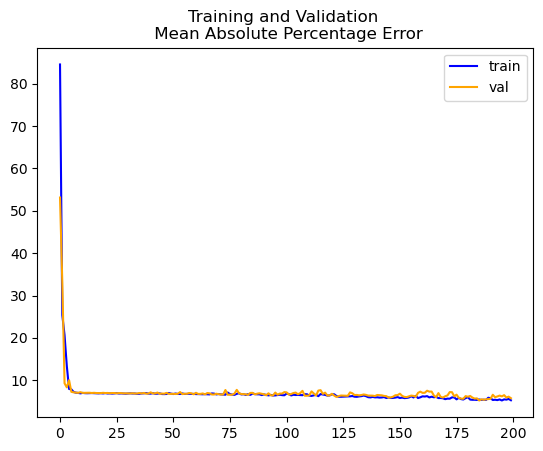

In [14]:
# FIT model with TRAINING DATA
history = model.fit(train_dataset, validation_data=test_dataset,epochs=NUM_EPOCHS,verbose=2)
model.summary()

# EVALUATE model with TESTING DATA
model.evaluate(test_dataset, verbose=0)

ynew = model.predict(test_dataset)
print(f'Test Loss: {ynew[0]}')
print(f'Test Mean Squared Error: {ynew[1]}')
print(f'Test Mean Absolute Percentage Error: {ynew[2]}')
print(f'Test Root Mean Squared Error: {ynew[3]}')

fig, ax = plt.subplots()
ax.set_title('Training and Validation \n Mean Absolute Percentage Error') # loss = 100 * abs(y_true - y_pred) / y_true
ax.plot(history.history['mean_absolute_percentage_error'], color = 'blue', label = 'train')

# plt.title('Validation Mean Absolute Percentage Error (MAPE)') # loss = 100 * abs(y_true - y_pred) / y_true
ax.plot(history.history['val_mean_absolute_percentage_error'], color = 'orange', label = 'val')
ax.legend()

In [15]:
results = model.evaluate(test_dataset, batch_size=64)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - accuracy: 0.0000e+00 - loss: 15.2669 - mean_absolute_percentage_error: 5.7918 - mean_squared_error: 15.2669 - root_mean_squared_error: 5.6498


In [16]:
import tensorflow as tf
import numpy as np

# 重置数据集
def create_test_dataset(X_test_norm, y_test):
    return tf.data.Dataset.from_tensor_slices((X_test_norm, y_test.T)).batch(64)

# 创建测试数据集
test_dataset = create_test_dataset(X_test_norm, y_test)

# EVALUATE model with TESTING DATA
results = model.evaluate(test_dataset, verbose=0)
print(f'Test Loss: {results[0]}')
print(f'Test Mean Squared Error: {results[1]}')
print(f'Test Mean Absolute Percentage Error: {results[2]}')
print(f'Test Root Mean Squared Error: {results[3]}')

# PREDICT with TESTING DATA
ynew = model.predict(test_dataset)

# 重置测试数据集
test_dataset = create_test_dataset(X_test_norm, y_test)

# EVALUATE model again with TESTING DATA
results = model.evaluate(test_dataset, batch_size=64)
print(f'loss: {results[0]} - accuracy: {results[1]} - mean_squared_error: {results[2]} - mean_absolute_percentage_error: {results[3]} - root_mean_squared_error: {results[4]}')


Test Loss: 15.071640968322754
Test Mean Squared Error: 0.0
Test Mean Absolute Percentage Error: 15.071640968322754
Test Root Mean Squared Error: 5.754553318023682
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 356ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 370ms/step - accuracy: 0.0000e+00 - loss: 15.0367 - mean_absolute_percentage_error: 5.7726 - mean_squared_error: 15.0367 - root_mean_squared_error: 5.6444
loss: 15.071640968322754 - accuracy: 0.0 - mean_squared_error: 15.071640968322754 - mean_absolute_percentage_error: 5.754553318023682 - root_mean_squared_error: 5.644092559814453


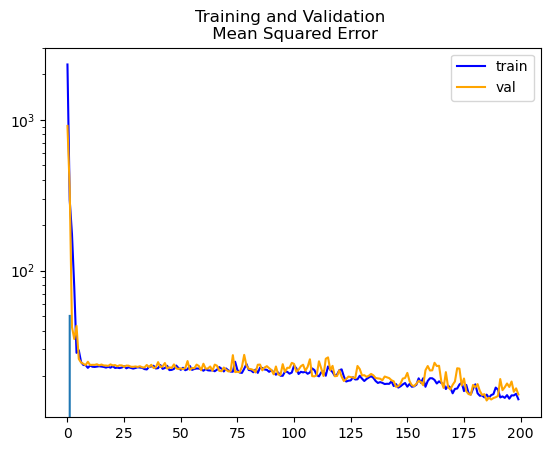

In [17]:
# plt.figure()
# plt.title('Loss (Mean Squared Error)')
# plt.plot(history.history['loss'])
# plt.figure()
# plt.title('Accuracy')
# plt.plot(history.history['accuracy'])
# plt.figure()
# plt.title('Mean Squared Error')
# plt.plot(history.history['mean_squared_error'])
# plt.figure()
fig, ax = plt.subplots()
ax.set_title('Training and Validation \n Mean Squared Error') # loss = 100 * abs(y_true - y_pred) / y_true
ax.plot(history.history['loss'], color = 'blue', label = 'train')
# plt.figure()
## Validation Plots
# plt.title('Validation Loss (MSE)') # loss = 100 * abs(y_true - y_pred) / y_true
# plt.plot(history.history['val_loss'])
# plt.figure()

# plt.title('Validation Mean Absolute Percentage Error (MAPE)') # loss = 100 * abs(y_true - y_pred) / y_true
ax.plot(history.history['val_loss'], color = 'orange', label = 'val')
ax.semilogy((0,50))
ax.legend()
# plt.figure()

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import load_model
import numpy as np

y_pred = model.predict(X_test)

# 计算评估指标
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)  # RMSE
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R^2: {r2}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 241ms/step
MSE: 5.015487222081084e+16
RMSE: 223952834.8130714
MAE: 223623313.612
R^2: -2176554443588038.5


/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
